# Aprendizaje por refuerzo I


Myrna Degano (16Co2024 - a1618)


## Desafío Práctico - Consigna

El desafío consiste en desarrollar un script en Python que permita encontrar, mediante un algoritmo de aprendizaje por refuerzo, una solución óptima a un
problema simple a elección aplicando cualquiera de las técnicas de Aprendizaje por Refuerzo del cursado, es decir, Monte Carlo ES, Monte Carlo IS (ordinario o ponderado), SARSA, Q-Learning o Deep Q-Network.

Puede utilizar bibliotecas como Gymnasium, MiniHack, MuJoCo (u otras del interés del estudiante) para los environments, o bien crear un environment propio.


In [1]:
!pip install gymnasium[toy-text] matplotlib pandas

## Generación del entorno

Se utiliza el entorno **"Taxi-v3"** de ***Gymnasium***.

Consiste en un entorno en el que un taxi autónomo debe aprender a:
*   Recoger a un pasajero en una ubicación específica.
*   Llevarlo a su destino.
*   Realizar esto moviéndose en una cuadrícula con restricciones.



In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import requests
import random
import pandas as pd
from matplotlib import animation
from IPython.display import HTML
from gymnasium import spaces
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [3]:
# Crear el entorno Taxi
# Devolver cada frame como un array de imagen
env = gym.make("Taxi-v3", render_mode="rgb_array", max_episode_steps=20)


El taxi se mueve en una cuadrícula de 5x5 celdas, con paredes internas que impiden ciertos movimientos.

Hay cuatro ubicaciones fijas que son los posibles puntos de origen y destino del pasajero.

(R = Red, G = Green, Y = Yellow, B = Blue)

**Acciones posibles:**

0: Move south (down)

1: Move north (up)

2: Move east (right)

3: Move west (left)

4: Pickup passenger

5: Drop off passenger

Cada **estado** se representa como un número entero entre 0 y 499 (hay 500 posibles estados discretos (5x5x5x4)).

* Posición fila del taxi (0-4)
* Posición columna del taxi (0-4)
* Ubicación del pasajero (R, G, Y, B o “en el taxi”)
* Destino (R, G, Y, B)

**Recompensas**:

* +20 por dejar al pasajero en el destino correcto.
* -1 por cada acción que no sea el dropoff exitoso (penaliza la demora).
* -10 por intentos inválidos de pickup o dropoff.

El episodio **termina** cuando:

* Termination = 1 (drop off exitoso del pasajero)
* Truncation (time_limit wrapper) = 1 (Máx. steps: 200)

El **estado inicial** es una observación aleatoria formada por:
* Una posición del taxi (fila y columna).
* Una ubicación del pasajero (R, G, Y, B).
* Un destino (R, G, Y, B), diferente de la ubicación.

(25x4x3) = 300 estados iniciales posibles.

In [4]:
# Simular un episodio con acciones aleatorias
def execute_random_episode(env):

    # Reiniciar el entorno a su estado inicial
    # Fijar la semilla aleatoria para que la simulación sea reproducible
    state, info = env.reset(seed=42)

    # Almacenar frames para la animación del resultado
    frames = [env.render()] # Estado inicial
    rewards = ['-']
    actions = ['-']

    terminated = False
    truncated = False
    step_count = 0

    while not (terminated or truncated):

        # Acción aleatoria => POLÍTICA RANDOM A SER REEMPLAZADA LUEGO POR EL AGENTE
        action = env.action_space.sample()

        state, reward, terminated, truncated, info = env.step(action)

        rewards.append(reward)
        actions.append(action)
        frames.append(env.render())
        step_count += 1

    env.close()

    return frames, rewards, actions

Para probar el entorno se ejecuta inicialmente con acciones aleatorias.

In [5]:
frames, rewards, actions = execute_random_episode(env)

In [6]:
def generateVideo(size, iframe, frames, rewards, actions, interval_seg):

    """
    Función para mostrar los movimientos del agente en video
    """
    # Crear figura
    fig, ax = plt.subplots(figsize=size)
    plt.axis('off')
    im = ax.imshow(iframe)
    title = ax.set_title(f"Step 0 | Action: - | Reward: 0")

    # Función de actualización
    def update(i):
        im.set_array(frames[i])
        title.set_text(f"Step {i+1} | Action: {desc_action[actions[i]]} | Reward: {rewards[i]}")
        return [im, title]

    # Animación
    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=interval_seg*1000, blit=True)
    plt.close()

    video_html = ani.to_html5_video()

    # Quitar bucle y añadir estilos
    video_html = video_html.replace('loop', '')
    video_html = video_html.replace(
        '<video ',
        '''<video style="
            display: block;
            margin: 20px auto;
            border: 3px solid #444;
            border-radius: 12px;
            box-shadow: 4px 4px 12px rgba(0,0,0,0.3);
            width: 500px;
            max-width: 100%;
        " '''
    )

    return video_html


In [7]:
desc_action = ["south", "north", "east", "west", "pick", "drop"]

Se genera video de muestra con el entorno provisto por defecto por Gymnasium.

In [8]:
resultVideo = generateVideo((5,5), frames[0], frames[1:], rewards[1:], actions[1:], 1)

# Mostrar el HTML resultante
HTML(resultVideo)

## Personalización del entorno

Para generar un entorno alternativo al estándar ofrecido por defecto en la biblioteca, se genera una clase que permita extender el entorno original y personalizarlo.

In [9]:
class CustomTaxiEnv(gym.Env):
    """
    Entorno personalizado a partir de Taxi de Gymnasium.

    Parámetros:
    - grid_size: tupla (filas, columnas) del tamaño del mapa.
    - destination_locs: lista de tuplas con posiciones (fila, columna) de destinos.
    - walls: conjunto de celdas que representan paredes/obstáculos.
    - stocastic: el movimiento del taxi es estocástico (% de acción correcta).
    - fickle_passenger: si True, el pasajero puede cambiar de destino una vez tras ser recogido.
    """

    metadata = {'render.modes': ["rgb_array"]}  # Modo de renderizado soportado

    def __init__(self,
                 grid_size=(5, 5),
                 destination_locs=None,
                 max_steps=200,
                 walls=None,
                 stocastic=0,
                 fickle_passenger=False,
                 verbose=False):

        super().__init__()

        taxi_url = "https://drive.google.com/uc?export=download&id=1KAB_ndvYb-ynP4KuFl0iMb-q-mqlmiAa"
        passenger_url = "https://drive.google.com/uc?export=download&id=1XFAtCStguKm9JbDAXwXPqcSm4Uwa8XPb"

        # Tamaño de la grilla
        self.grid_rows, self.grid_cols = grid_size

        response = requests.get(taxi_url)
        img = Image.open(BytesIO(response.content)).convert("RGBA")
        self.taxi_icon = np.array(img)

        response = requests.get(passenger_url)
        img = Image.open(BytesIO(response.content)).convert("RGBA")
        self.passenger_icon = np.array(img)

        # Parámetros de comportamiento
        self.stocastic = stocastic
        self.fickle_passenger = fickle_passenger
        self.fickle_triggered = False  # Controla si pasajero ya cambió destino
        self.render_mode = "rgb_array"
        self.max_steps = max_steps
        self.step_count = 0
        self.verbose = verbose

        # Destinos configurados o default en esquinas
        if destination_locs is None:
            self.locs = [
                (0, 0),
                (0, self.grid_cols - 1),
                (self.grid_rows - 1, 0),
                (self.grid_rows - 1, self.grid_cols - 1)
            ]
        else:
            self.locs = destination_locs

        self.num_destinations = len(self.locs)  # Número de destinos posibles

        # Definición del espacio de acciones (6 acciones posibles)
        # 0: south, 1: north, 2: east, 3: west, 4: pickup, 5: dropoff
        self.action_space = spaces.Discrete(6)

        # Espacio de observación:
        # Estado codificado como un número único a partir de
        # posición del taxi, ubicación del pasajero, destino
        self.observation_space = spaces.Discrete(
            self.grid_rows * self.grid_cols * (self.num_destinations + 1) * self.num_destinations
        )

        # Definición de paredes/obstáculos en celdas
        self.walls = walls if walls else set()

        # Inicializar estado llamando a reset()
        self.reset()

    def encode(self, taxi_row, taxi_col, passenger_loc, dest_idx):
        """
        Codifica las variables del estado en un único entero.

        taxi_row, taxi_col: posición del taxi
        passenger_loc: índice de ubicación del pasajero o 'en taxi' (num_destinations)
        dest_idx: índice del destino

        Devuelve un entero que representa ese estado.
        """
        i = taxi_row
        i *= self.grid_cols
        i += taxi_col
        i *= (self.num_destinations + 1)
        i += passenger_loc
        i *= self.num_destinations
        i += dest_idx
        return i

    def decode(self, i):
        """
        Decodifica el entero de estado a las variables originales.

        Devuelve (taxi_row, taxi_col, passenger_loc, dest_idx).
        """
        out = []
        out.append(i % self.num_destinations)
        i //= self.num_destinations
        out.append(i % (self.num_destinations + 1))
        i //= (self.num_destinations + 1)
        out.append(i % self.grid_cols)
        i //= self.grid_cols
        out.append(i)
        return tuple(reversed(out))

    def reset(self, *, seed=None, options=None):
        """
        Reinicia el entorno a un estado inicial aleatorio.

        Devuelve la observación inicial y un diccionario info vacío.
        """
        super().reset(seed=seed)
        self.fickle_triggered = False  # Reiniciar el cambio de destino
        self.step_count = 0  # Reiniciar el contador de pasos

        # Taxi en posición aleatoria en la grilla
        self.taxi_row = self.np_random.integers(0, self.grid_rows)
        self.taxi_col = self.np_random.integers(0, self.grid_cols)

        # Pasajero en una ubicación inicial (uno de los destinos)
        self.passenger_loc = self.np_random.integers(0, self.num_destinations)

        # Elegir destino distinto del origen
        self.dest_idx = self.np_random.integers(0, self.num_destinations)
        while self.dest_idx == self.passenger_loc:
            self.dest_idx = self.np_random.integers(0, self.num_destinations)

        # Guardar el origen para posible comportamiento del pasajero indeciso
        self.last_pickup_source = self.passenger_loc

        return self._get_obs(), {}

    def _get_obs(self):
        """
        Obtiene la observación codificada actual.
        """
        return self.encode(self.taxi_row, self.taxi_col, self.passenger_loc, self.dest_idx)

    def _apply_stocastic_movement(self, action):
        """
        - % de hacer la acción correcta.
        Se mueve en la dirección deseada (action) con una cierta probabilidad self.stocastic
        O se desvía aleatoriamente hacia la izquierda o derecha con igual probabilidad

        """
        if self.np_random.uniform() < self.stocastic:
            return action
        left = {0: 3, 1: 2, 2: 0, 3: 1}  # Mapeo de acción a giro izquierda
        right = {0: 2, 1: 3, 2: 1, 3: 0}  # Mapeo de acción a giro derecha
        return left[action] if self.np_random.uniform() < 0.5 else right[action]

    def step(self, action):
        """
        Ejecuta una acción en el entorno.

        Devuelve: (observación, recompensa, terminado, truncado, info)
        """
        reward = -1  # Penalización por paso
        terminated = False
        truncated = False

        # Modificar acción según probabilidad
        if self.stocastic > 0 and action in [0,1,2,3]:  # Sólo afecta movimientos
            action = self._apply_stocastic_movement(action)

        # Variables temporales para la nueva posición del taxi
        new_row, new_col = self.taxi_row, self.taxi_col

        # Movimiento del taxi con chequeo de paredes y bordes
        if action == 0 and self.taxi_row < self.grid_rows - 1:
            if (self.taxi_row + 1, self.taxi_col) not in self.walls:
                new_row += 1
        elif action == 1 and self.taxi_row > 0:
            if (self.taxi_row - 1, self.taxi_col) not in self.walls:
                new_row -= 1
        elif action == 2 and self.taxi_col < self.grid_cols - 1:
            if (self.taxi_row, self.taxi_col + 1) not in self.walls:
                new_col += 1
        elif action == 3 and self.taxi_col > 0:
            if (self.taxi_row, self.taxi_col - 1) not in self.walls:
                new_col -= 1

        # Acciones de pickup y dropoff
        elif action == 4:  # pickup
            # Sólo funciona si taxi está en la posición del pasajero y pasajero no está en taxi
            if self.passenger_loc < self.num_destinations and (self.taxi_row, self.taxi_col) == self.locs[self.passenger_loc]:
                self.passenger_loc = self.num_destinations  # Pasajero sube al taxi
            else:
                reward = -10  # Pickup inválido penalizado

        elif action == 5:  # dropoff
            # Si pasajero está en taxi y taxi está en destino correcto
            if self.passenger_loc == self.num_destinations and (self.taxi_row, self.taxi_col) == self.locs[self.dest_idx]:
                reward = 20
                terminated = True  # Episodio termina con éxito
            # Dropoff en otra ubicación válida (solo deja pasajero ahí)
            elif self.passenger_loc == self.num_destinations and (self.taxi_row, self.taxi_col) in self.locs:
                self.passenger_loc = self.locs.index((self.taxi_row, self.taxi_col))
            else:
                reward = -10  # Dropoff inválido penalizado

        # Actualizar posición del taxi
        self.taxi_row, self.taxi_col = new_row, new_col

        # Comportamiento pasajero indeciso (solo una vez después de pickup)
        if self.fickle_passenger and not self.fickle_triggered and self.passenger_loc == self.num_destinations:
            src_row, src_col = self.locs[self.last_pickup_source]
            dist = abs(self.taxi_row - src_row) + abs(self.taxi_col - src_col)
            if dist >= 1 and self.np_random.uniform() < 0.3:
                posibles = [i for i in range(self.num_destinations) if i != self.dest_idx]
                self.dest_idx = self.np_random.choice(posibles)
                self.fickle_triggered = True


        # Aumentar el contador de pasos
        self.step_count += 1

        # Verificar si se supera el máximo permitido
        if self.step_count >= self.max_steps:
            truncated = True

        if self.verbose:
            print(f"STEP: {self.step_count} ACTION: {desc_action[action]} TAXI: ({self.taxi_row}, {self.taxi_col}) PASSENGER LOC: {self.passenger_loc} DEST IDX: {self.dest_idx}, DEST LOC: {self.locs[self.dest_idx]} TERMINATED: {terminated} TRUNCATED: {truncated}")

        return self._get_obs(), reward, terminated, truncated, {}

    def render(self, mode='rgb_array'):
        """
        Renderiza el estado actual del entorno y devuelve una imagen RGB (np.array).
        """

        # Crear figura y canvas
        fig, ax = plt.subplots(figsize=(5, 5))
        canvas = FigureCanvas(fig)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, self.grid_cols)
        ax.set_ylim(0, self.grid_rows)
        ax.invert_yaxis()

        # Dibujar la grilla
        for r in range(self.grid_rows):
            for c in range(self.grid_cols):
                color = 'white'
                pos = (r, c)
                if pos == (self.taxi_row, self.taxi_col):
                    color = '#FFCDD2' # Posición del taxi
                elif pos == self.locs[self.dest_idx]:
                    color = '#B3E5FC'  # Destino (celda donde hay que dejar al pasajero)
                elif self.passenger_loc < self.num_destinations and pos == self.locs[self.passenger_loc]:
                    color = '#FFF9C4'  # Posición del pasajero esperando
                elif pos in self.locs:
                    color = '#C8E6C9' # Otros destinos posibles
                elif pos in self.walls:
                    color = '#D7CCC8' # Obstáculos

                ax.add_patch(plt.Rectangle((c, r), 1, 1, facecolor=color, edgecolor='black'))


        # Dibujar el taxi como imagen
        imagebox = OffsetImage(self.taxi_icon, zoom=0.2)
        ab = AnnotationBbox(imagebox, (self.taxi_col + 0.5, self.taxi_row + 0.5), frameon=False)
        ax.add_artist(ab)


        # Dibujar la imagen del pasajero si está esperando (fuera del taxi)
        if self.passenger_loc < self.num_destinations:
            passenger_pos = self.locs[self.passenger_loc]
            imagebox = OffsetImage(self.passenger_icon, zoom=0.2)
            ab = AnnotationBbox(imagebox, (passenger_pos[1] + 0.5, passenger_pos[0] + 0.5), frameon=False)
            ax.add_artist(ab)

        # Convertir a imagen RGB
        canvas.draw()
        buf = canvas.buffer_rgba()
        image = np.frombuffer(buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (4,))
        image = image[:, :, :3]  # Quitar el canal alfa

        plt.close(fig)
        return image




Con la nueva clase custom se puede instanciar un entorno donde se modifica:

* El tamaño de la grilla.
* La cantidad y posición de los destinos posibles.
* La cantidad y posición de obstáculos.
* El porcentaje de aleatoriedad si se desea que los movimientos sean estocásticos.
* La posibilidad de que el pasajero cambie de destino durante el viaje.
* Log con el detalle de los pasos.

In [10]:
env = CustomTaxiEnv(
    grid_size=(7, 7),
    destination_locs=[(0, 0), (2, 3), (1, 4), (5, 5)],
    max_steps=20,
    walls={(1, 1), (1, 2), (3, 3), (4, 3)},
    stocastic=0.8,
    fickle_passenger=True,
    verbose=True
)

In [11]:
frames, rewards, actions = execute_random_episode(env)

STEP: 1 ACTION: west TAXI: (0, 4) PASSENGER LOC: 2 DEST IDX: 1, DEST LOC: (2, 3) TERMINATED: False TRUNCATED: False
STEP: 2 ACTION: west TAXI: (0, 3) PASSENGER LOC: 2 DEST IDX: 1, DEST LOC: (2, 3) TERMINATED: False TRUNCATED: False
STEP: 3 ACTION: pick TAXI: (0, 3) PASSENGER LOC: 2 DEST IDX: 1, DEST LOC: (2, 3) TERMINATED: False TRUNCATED: False
STEP: 4 ACTION: north TAXI: (0, 3) PASSENGER LOC: 2 DEST IDX: 1, DEST LOC: (2, 3) TERMINATED: False TRUNCATED: False
STEP: 5 ACTION: pick TAXI: (0, 3) PASSENGER LOC: 2 DEST IDX: 1, DEST LOC: (2, 3) TERMINATED: False TRUNCATED: False
STEP: 6 ACTION: south TAXI: (1, 3) PASSENGER LOC: 2 DEST IDX: 1, DEST LOC: (2, 3) TERMINATED: False TRUNCATED: False
STEP: 7 ACTION: south TAXI: (2, 3) PASSENGER LOC: 2 DEST IDX: 1, DEST LOC: (2, 3) TERMINATED: False TRUNCATED: False
STEP: 8 ACTION: pick TAXI: (2, 3) PASSENGER LOC: 2 DEST IDX: 1, DEST LOC: (2, 3) TERMINATED: False TRUNCATED: False
STEP: 9 ACTION: south TAXI: (2, 3) PASSENGER LOC: 2 DEST IDX: 1, DEST

Ejemplo del nuevo entorno Taxi custom con acciones aleatorias.

In [12]:
resultVideo = generateVideo((5,5), frames[0], frames[1:], rewards[1:], actions[1:], 1)

# Mostrar el HTML resultante
HTML(resultVideo)

## Q-learning

Se selecciona Q-learning para el aprendizaje del agente por su simplicidad, eficiencia computacional y la suficiencia del algoritmo para entornos con espacios de estado relativamente pequeños y discretos, como en este caso.

Como valores por defecto de los parámetros se considera:

* **alpha (Tasa de aprendizaje): 0.5** - Controla qué tan rápido se actualiza el valor de la tabla Q. Es decir, cuánto se "aprende" de cada nuevo dato que recibe el agente. Un valor alto de alpha significa que el agente dará más peso a la nueva información en lugar de la información almacenada en la tabla Q, mientras que un valor bajo significa que el agente dará más peso a lo aprendido previamente.  

* **gamma (Factor de descuento): 0.95** - Este parámetro decide cuánta importancia darle a las recompensas futuras en comparación con las inmediatas. Un valor de gamma cercano a 1.0 indica que el agente valorará mucho las recompensas futuras, mientras que un valor cercano a 0 hace que el agente se enfoque más en las recompensas inmediatas.  En este caso, 0.95 sugiere que el agente valora un poco más las recompensas futuras, pero también se interesa por las recompensas inmediatas.  

* **epsilon_start: 1** - Es el valor inicial de epsilon, que determina el porcentaje de veces que el agente va a explorar el espacio de acciones (en lugar de explotar la mejor acción conocida).  1.0 significa que al principio el agente será completamente exploratorio, eligiendo acciones al azar. Con el tiempo, epsilon disminuirá, lo que hará que el agente se enfoque más en explotar lo aprendido.  

* **epsilon_min: 0.05** - Este es el valor mínimo que epsilon puede alcanzar. Después de cada episodio, epsilon se irá reduciendo, pero nunca por debajo de este valor. Esto asegura que el agente siga explorando algo, incluso cuando el entrenamiento ya esté más avanzado. El valor 0.05 indica que el agente explorará una pequeña fracción del tiempo, incluso al final del entrenamiento.

* **epsilon_decay: 0.995** - Este parámetro controla la velocidad con la que epsilon disminuye. Un valor de 0.995 significa que epsilon se reducirá en un 0.5% en cada episodio. Con esta tasa, el agente comenzará a explotar más y a explorar menos conforme avance el entrenamiento.


In [13]:
def q_learning(env, episodes=1000, alpha=0.5, gamma=0.95, epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995, max_steps=200):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    epsilon = epsilon_start
    rewards_all_episodes = []

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_rewards = 0

        for step in range(max_steps):
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Actualizar Q-table usando la fórmula de Q-learning
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state
            total_rewards += reward

            if done:
                break

        # Decaimiento de epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_all_episodes.append(total_rewards)

        # Mostrar progreso cada 100 episodios
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_all_episodes[-100:])
            print(f"Episode {episode+1}/{episodes} - Avg Reward (last 100): {avg_reward:.2f} - Epsilon: {epsilon:.3f}")

    return q_table, rewards_all_episodes

In [14]:
env = CustomTaxiEnv(
    grid_size=(7, 7),
    destination_locs=[(0, 0), (2, 3), (1, 4), (5, 5)],
    max_steps=20,
    walls={(1, 1), (1, 2), (3, 3), (4, 3), (5, 3), (5, 4)},
    stocastic=0,
    fickle_passenger=False,
    verbose=False
)

Resultados del entrenamiento.

In [15]:
q_table, rewards_all_episodes = q_learning(env, episodes=15000)

Episode 100/15000 - Avg Reward (last 100): -68.87 - Epsilon: 0.606
Episode 200/15000 - Avg Reward (last 100): -63.29 - Epsilon: 0.367
Episode 300/15000 - Avg Reward (last 100): -55.37 - Epsilon: 0.222
Episode 400/15000 - Avg Reward (last 100): -40.88 - Epsilon: 0.135
Episode 500/15000 - Avg Reward (last 100): -28.73 - Epsilon: 0.082
Episode 600/15000 - Avg Reward (last 100): -24.41 - Epsilon: 0.050
Episode 700/15000 - Avg Reward (last 100): -26.57 - Epsilon: 0.050
Episode 800/15000 - Avg Reward (last 100): -25.94 - Epsilon: 0.050
Episode 900/15000 - Avg Reward (last 100): -25.38 - Epsilon: 0.050
Episode 1000/15000 - Avg Reward (last 100): -25.30 - Epsilon: 0.050
Episode 1100/15000 - Avg Reward (last 100): -21.67 - Epsilon: 0.050
Episode 1200/15000 - Avg Reward (last 100): -23.55 - Epsilon: 0.050
Episode 1300/15000 - Avg Reward (last 100): -22.88 - Epsilon: 0.050
Episode 1400/15000 - Avg Reward (last 100): -23.51 - Epsilon: 0.050
Episode 1500/15000 - Avg Reward (last 100): -20.27 - Epsi

Se grafica la recompensa a lo largo de los episodios para verificar la convergencia de la curva durante el entrenamiento.

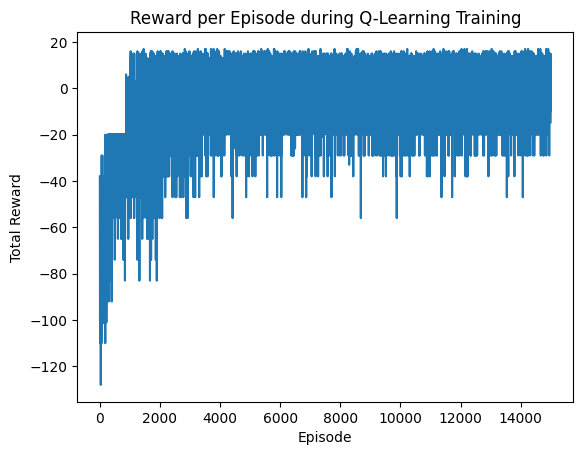

In [16]:
# Graficar
plt.plot(rewards_all_episodes)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode during Q-Learning Training')
plt.show()


Suavizando la curva para una mejor visualización, se observa claramente la convergencia en el aprendizaje.

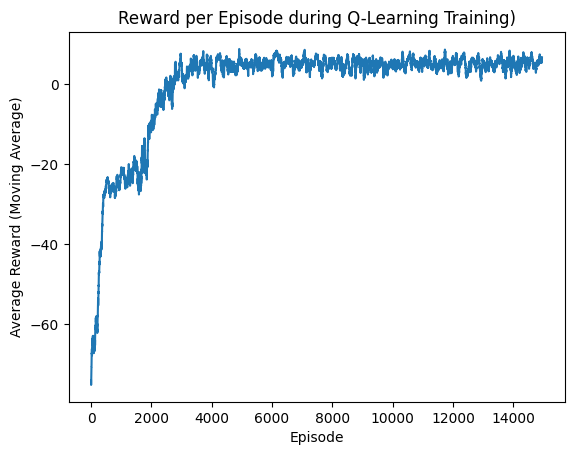

In [17]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50
smoothed_rewards = moving_average(rewards_all_episodes, window_size)

plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward (Moving Average)')
plt.title(f'Reward per Episode during Q-Learning Training)')
plt.show()


Últimos 5 estados de Q-table.  

Los valores en cada celda de la tabla son los valores Q de cada acción en ese estado. Los valores Q representan la calidad de la acción en ese estado, es decir, cuán buena es esa acción según el aprendizaje del agente hasta ese momento.

El agente elige la acción con el valor Q más alto en un estado dado, ya que esto indica que es la acción que, en teoría, llevará a la mayor recompensa acumulada a largo plazo.

In [18]:
# Últimos 5 estados de la Q-table
last_5_states = q_table[-5:]

# Convertir la Q-table de los últimos 5 estados en un DataFrame de pandas
df = pd.DataFrame(last_5_states, columns=desc_action)

display(df.style.hide(axis='index'))


south,north,east,west,pick,drop
0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-4.473408,-4.464309,-4.473408,-4.683455,-9.159246,-5.000000
-3.248168,-2.984665,-3.248168,134.758998,-5.000000,-5.000000
-2.493944,-2.754633,-2.818634,202.060394,-5.000000,-5.000000
-0.500000,-0.500000,-0.500000,179.497292,0.000000,0.000000


Se crea la siguiente función para evaluar el aprendizaje del agente.

In [19]:
def evaluate_agent_detailed(env, q_table, episodes=1, max_steps=200):
    all_frames = []
    all_actions = []
    all_rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        frames = [env.render()] # Frame inicial
        actions = [0]
        rewards = [0]
        step_count = 0

        while not done and step_count < max_steps:
            action = np.argmax(q_table[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            frames.append(env.render())
            actions.append(action)
            rewards.append(reward)

            state = next_state
            step_count += 1

        all_frames.append(frames)
        all_actions.append(actions)
        all_rewards.append(rewards)

    return all_frames, all_actions, all_rewards


In [20]:
# Evaluar guardando frames, acciones y recompensas
all_frames, all_actions, all_rewards = evaluate_agent_detailed(env, q_table, episodes=1)


Se genera video mostrando cómo el agente realiza la acción esperada de manera correcta luego del aprendizaje.

In [21]:
resultVideo = generateVideo((5,5), all_frames[0][0], all_frames[0][1:], all_rewards[0][1:], all_actions[0][1:], 1)

# Mostrar el HTML resultante
HTML(resultVideo)


## Referencias





*   Material de clase "Aprendizaje por refuerzo I"  
https://campusposgrado.fi.uba.ar/course/view.php?id=412  

  https://github.com/aear-uba/ar1/tree/ar1-2025-b3
  <br>
  
*   Gymnasium Documentation  
https://gymnasium.farama.org/index.html



<p align="center">
  <img src="https://gymnasium.farama.org/_images/AE_loop.png" width="300"><br>
</p>
